<a href="https://colab.research.google.com/github/mukund-rajukumar/My-VisionAI-Projects/blob/main/FoodAndBevPackageDetection/Detection_with_LLAMA3V.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %pip install ipywidgets

%pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 84.1 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.44.2
    Uninstalling transformers-4.44.2:
      Successfully uninstalled transformers-4.44.2


In [2]:
#@title Login to Hugging Face to access the Llamma3 (gated) model
from huggingface_hub import login
from google.colab import userdata

hf_token = userdata.get('HF-W-TOKEN')

login(token=hf_token, add_to_git_credential=True)

Token is valid (permission: write).
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [3]:
#@title Install Dependencies
import importlib.util # Import the importlib module

if importlib.util.find_spec('tabulate') is None:
  %pip install tabulate

if importlib.util.find_spec('timm') is None:
  %pip install timm

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import numpy as np
import os
import yaml
import time
import re

import torch
import transformers
#from transformers import AutoTokenizer, AutoModel
from transformers import MllamaForConditionalGeneration, AutoProcessor

import math
import torchvision.transforms as T
from torchvision.transforms.functional import InterpolationMode

from pathlib import Path

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 44.6 MB/s eta 0:00:00


In [4]:
#@title Function: Load class names from yaml file

def load_class_labels(yaml_path):
  """Loads class labels from a YAML file.

  Args:
      yaml_path (str): The path to the YAML file containing the class labels.

  Returns:
      list: A list of class labels.
  """

  with open(yaml_path, 'r') as file:
    data = yaml.safe_load(file)
  return data['names']  # 'names' contains the list of class labels

In [5]:
#@title Function: Extract bounding boxes and class names from Yolo format test data and overlay on image

def extract_and_plot_image_bboxes(img, label_path, class_labels):
  """Extracts bounding boxes and class labels from a label file and plots them on an image.

  Args:
      img (Image.Image): The image to plot the bounding boxes on.
      label_path (str): The path to the label file containing bounding box information.
      class_labels (list): A list of class labels corresponding to the class IDs in the label file.

  Returns:
      list: A list of dictionaries containing extracted image label information (class ID and bounding box coordinates).

  Raises:
      ValueError: If the label file format is invalid (expected format: class_id x_center y_center width height per line).
  """

  # Create a plot
  fig, ax = plt.subplots(1, figsize=(10, 10))
  ax.imshow(img)

  # Read the label file and extract bounding boxes
  image_labels = []
  try:
    with open(label_path, 'r') as f:
      for line in f.readlines():
        class_id, x_center, y_center, width, height = map(float, line.split())
        # Convert normalized coordinates to absolute pixel values
        x1n = (x_center - width / 2)
        y1n = (y_center - height / 2)
        x2n = (x_center + width / 2)
        y2n = (y_center + height / 2)
        image_labels.append({'class_id': class_id, 'bbox': (x1n, y1n, x2n, y2n)})
  except ValueError:
    raise ValueError(f"Invalid label file format. Expected format: class_id x_center y_center width height per line.")

  # Plot bounding boxes and labels
  for image_label in image_labels:
    class_id = image_label['class_id']
    x1n, y1n, x2n, y2n = image_label['bbox']
    img_w, img_h = img.size
    width_abs = (x2n - x1n) * img_w
    height_abs = (y2n - y1n) * img_h
    x_min = x1n * img_w
    y_min = y1n * img_h

    # Create a rectangle patch for the bounding box
    rect = patches.Rectangle((x_min, y_min), width_abs, height_abs, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    # Optionally, annotate the class label
    ax.text(x_min, y_min, class_labels[class_id], color='white', fontsize=12, bbox=dict(facecolor='r', edgecolor='r'))

  # Show the plot
  plt.show()
  return image_labels

In [6]:
#@title Load Llama model
import requests

model_id = "meta-llama/Llama-3.2-11B-Vision-Instruct"

model = MllamaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)
processor = AutoProcessor.from_pretrained(model_id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/5.07k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/89.4k [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/5.15k [00:00<?, ?B/s]

In [6]:
print(model)

MllamaForConditionalGeneration(
  (vision_model): MllamaVisionModel(
    (patch_embedding): Conv2d(3, 1280, kernel_size=(14, 14), stride=(14, 14), padding=valid, bias=False)
    (gated_positional_embedding): MllamaPrecomputedPositionEmbedding(
      (tile_embedding): Embedding(9, 8197120)
    )
    (pre_tile_positional_embedding): MllamaPrecomputedAspectRatioEmbedding(
      (embedding): Embedding(9, 5120)
    )
    (post_tile_positional_embedding): MllamaPrecomputedAspectRatioEmbedding(
      (embedding): Embedding(9, 5120)
    )
    (layernorm_pre): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    (layernorm_post): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    (transformer): MllamaVisionEncoder(
      (layers): ModuleList(
        (0-31): 32 x MllamaVisionEncoderLayer(
          (self_attn): MllamaVisionSdpaAttention(
            (q_proj): Linear(in_features=1280, out_features=1280, bias=False)
            (k_proj): Linear(in_features=1280, out_features=1280, b

In [7]:
model.num_parameters()

10670220835

In [8]:
for param in model.parameters():
  print(type(param), param.size())

<class 'torch.nn.parameter.Parameter'> torch.Size([1280])
<class 'torch.nn.parameter.Parameter'> torch.Size([1280, 3, 14, 14])
<class 'torch.nn.parameter.Parameter'> torch.Size([1])
<class 'torch.nn.parameter.Parameter'> torch.Size([1601, 1280])
<class 'torch.nn.parameter.Parameter'> torch.Size([9, 8197120])
<class 'torch.nn.parameter.Parameter'> torch.Size([1])
<class 'torch.nn.parameter.Parameter'> torch.Size([9, 5120])
<class 'torch.nn.parameter.Parameter'> torch.Size([1])
<class 'torch.nn.parameter.Parameter'> torch.Size([9, 5120])
<class 'torch.nn.parameter.Parameter'> torch.Size([1280])
<class 'torch.nn.parameter.Parameter'> torch.Size([1280])
<class 'torch.nn.parameter.Parameter'> torch.Size([1280])
<class 'torch.nn.parameter.Parameter'> torch.Size([1280])
<class 'torch.nn.parameter.Parameter'> torch.Size([1280, 1280])
<class 'torch.nn.parameter.Parameter'> torch.Size([1280, 1280])
<class 'torch.nn.parameter.Parameter'> torch.Size([1280, 1280])
<class 'torch.nn.parameter.Paramet

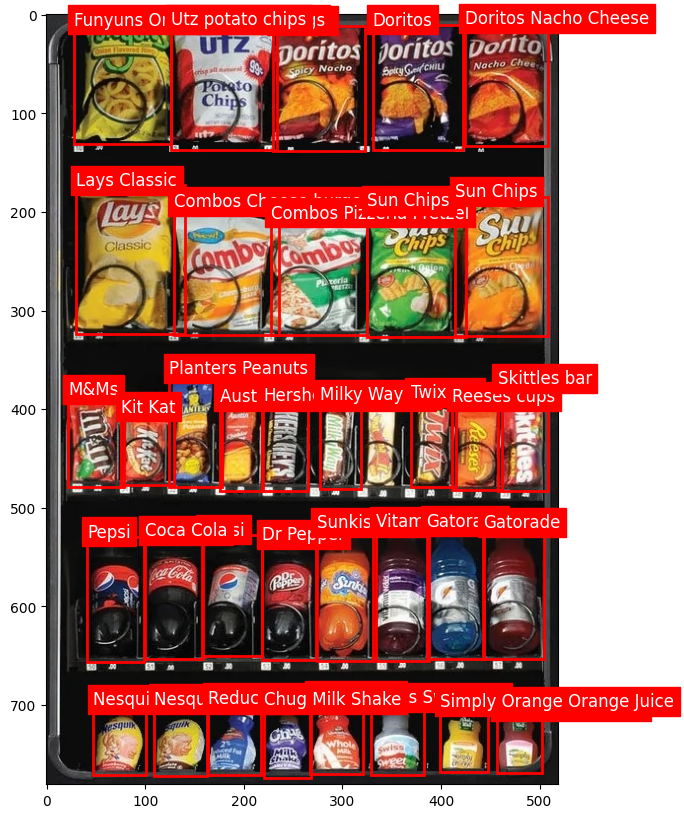

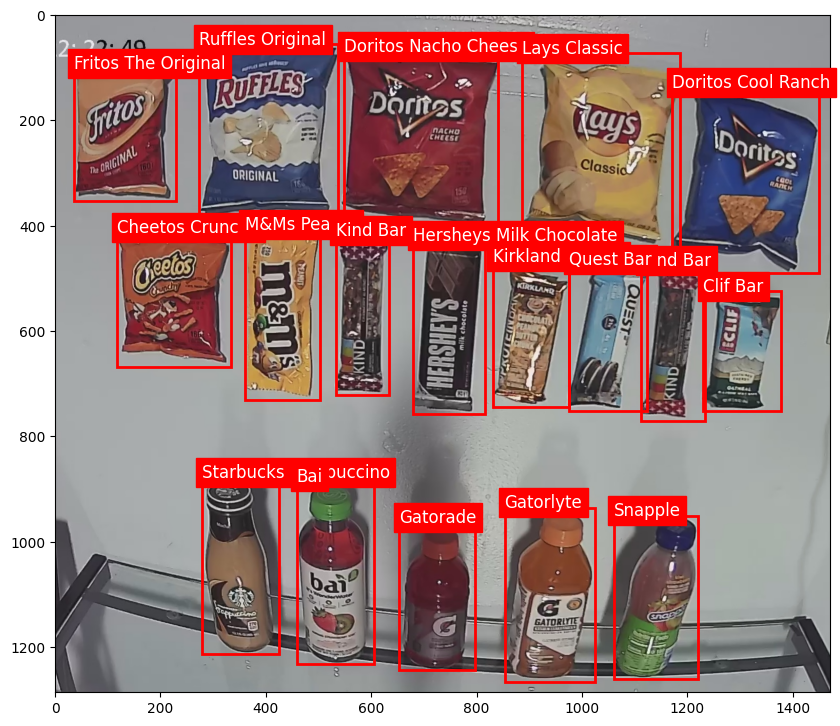

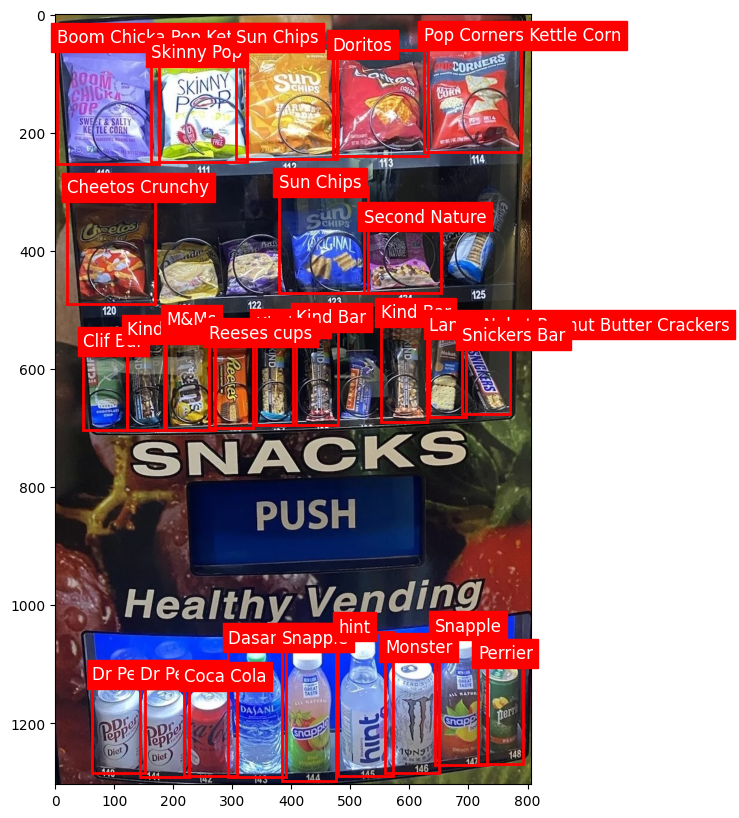

In [8]:
#@title Load Test Data
# Define paths to the dataset
dataset_dir = '.'
images_dir = os.path.join(dataset_dir, 'images')
labels_dir = os.path.join(dataset_dir, 'labels')
data_yaml_path = os.path.join(dataset_dir, 'data.yaml')

# Load class labels from the data.yaml file
class_labels = load_class_labels(data_yaml_path)

# List of image files
image_files = os.listdir(images_dir)
num_images = len(image_files)

# Loop through the test images and plot them with their bounding boxes
test_data = []
for image_file in image_files:
  image_path = os.path.join(images_dir, image_file)
  # image = cv2.imread(image_path)
  # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert image to RGB format for display
  image = Image.open(image_path)
  # print(f"{img_fname} dim: {images[-1].size}")
  label_path = os.path.join(labels_dir, image_file.replace('.jpg', '.txt'))  # Assuming the labels have the same name as the images
  labels = extract_and_plot_image_bboxes(image, label_path, class_labels)
  test_data.append({'image': image, 'filename': image_file, 'labels': labels})

In [11]:
llm_responses = []

# prompt = "<|image|><|begin_of_text|>This image shows multiple packaged food and beverage products. Provide the brand and full product name for each item. Don't use any markdown. Additionally, provide the bounding box coordinates for each product in the format [ymin, xmin, ymax, xmax]"
# prompt = "<|image|><|begin_of_text|>Describe the image"

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": "This image shows multiple packaged food and beverage products. Provide the brand and full product name for each item. Don't use any markdown. Additionally, provide the bounding box coordinates for each product in the format [ymin, xmin, ymax, xmax]"}
    ]}
]
input_text = processor.apply_chat_template(messages, add_generation_prompt=True)

for test_sample in test_data:
  image = test_sample['image']
  image_fname = test_sample['filename']
  print(image_fname)
  start_time = time.time()
  inputs = processor(image,
                     input_text,
                     add_special_tokens = False,
                     return_tensors="pt"
                     ).to(model.device)

  output = model.generate(**inputs, max_new_tokens=30)
  print(f'User: {input_text}\nAssistant: {processor.decode(output[0])}')
  end_time = time.time()
  print(f'Time taken: {end_time - start_time} seconds')

  # pred_labels = extract_pred_labels(output, image)
  pred_labels = []
  llm_responses.append({'prompt': input_text, 'model': model, 'response': output, 'ref_labels': test_sample['labels'], 'pred_labels': pred_labels, 'image_fname': image_fname})


vending3-1.jpg
User: <|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>This image shows multiple packaged food and beverage products. Provide the brand and full product name for each item. Don't use any markdown. Additionally, provide the bounding box coordinates for each product in the format [ymin, xmin, ymax, xmax]<|eot_id|><|start_header_id|>assistant<|end_header_id|>


Assistant: <|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>This image shows multiple packaged food and beverage products. Provide the brand and full product name for each item. Don't use any markdown. Additionally, provide the bounding box coordinates for each product in the format [ymin, xmin, ymax, xmax]<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Here is the list of products shown in the image, along with their bounding box coordinates:

1. Utz Spicy Nacho Doritos
  
Time taken: 14.757213830947876 seconds
vending2.jpg
User: <|begin_of_text|><|start_header_id|>user